In [ ]:
#packages per l'esecuzione del codice
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib
import imageio
import glob
import csv  
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)
!pip install keras-tuner --upgrade

import keras_tuner as kt

from matplotlib import style
style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [ ]:
# path per train e test
drive.mount('/content/drive',force_remount=True)
train_dir = '/content/drive/MyDrive/NEURALNETWORK/DatasetNN/train'
print("Train directory read correctly!")
test_dir = '/content/drive/MyDrive/NEURALNETWORK/DatasetNN/test'
print("Test directory read correctly!")
IMG_SIZE = 128

Mounted at /content/drive
Train directory read correctly!
Test directory read correctly!


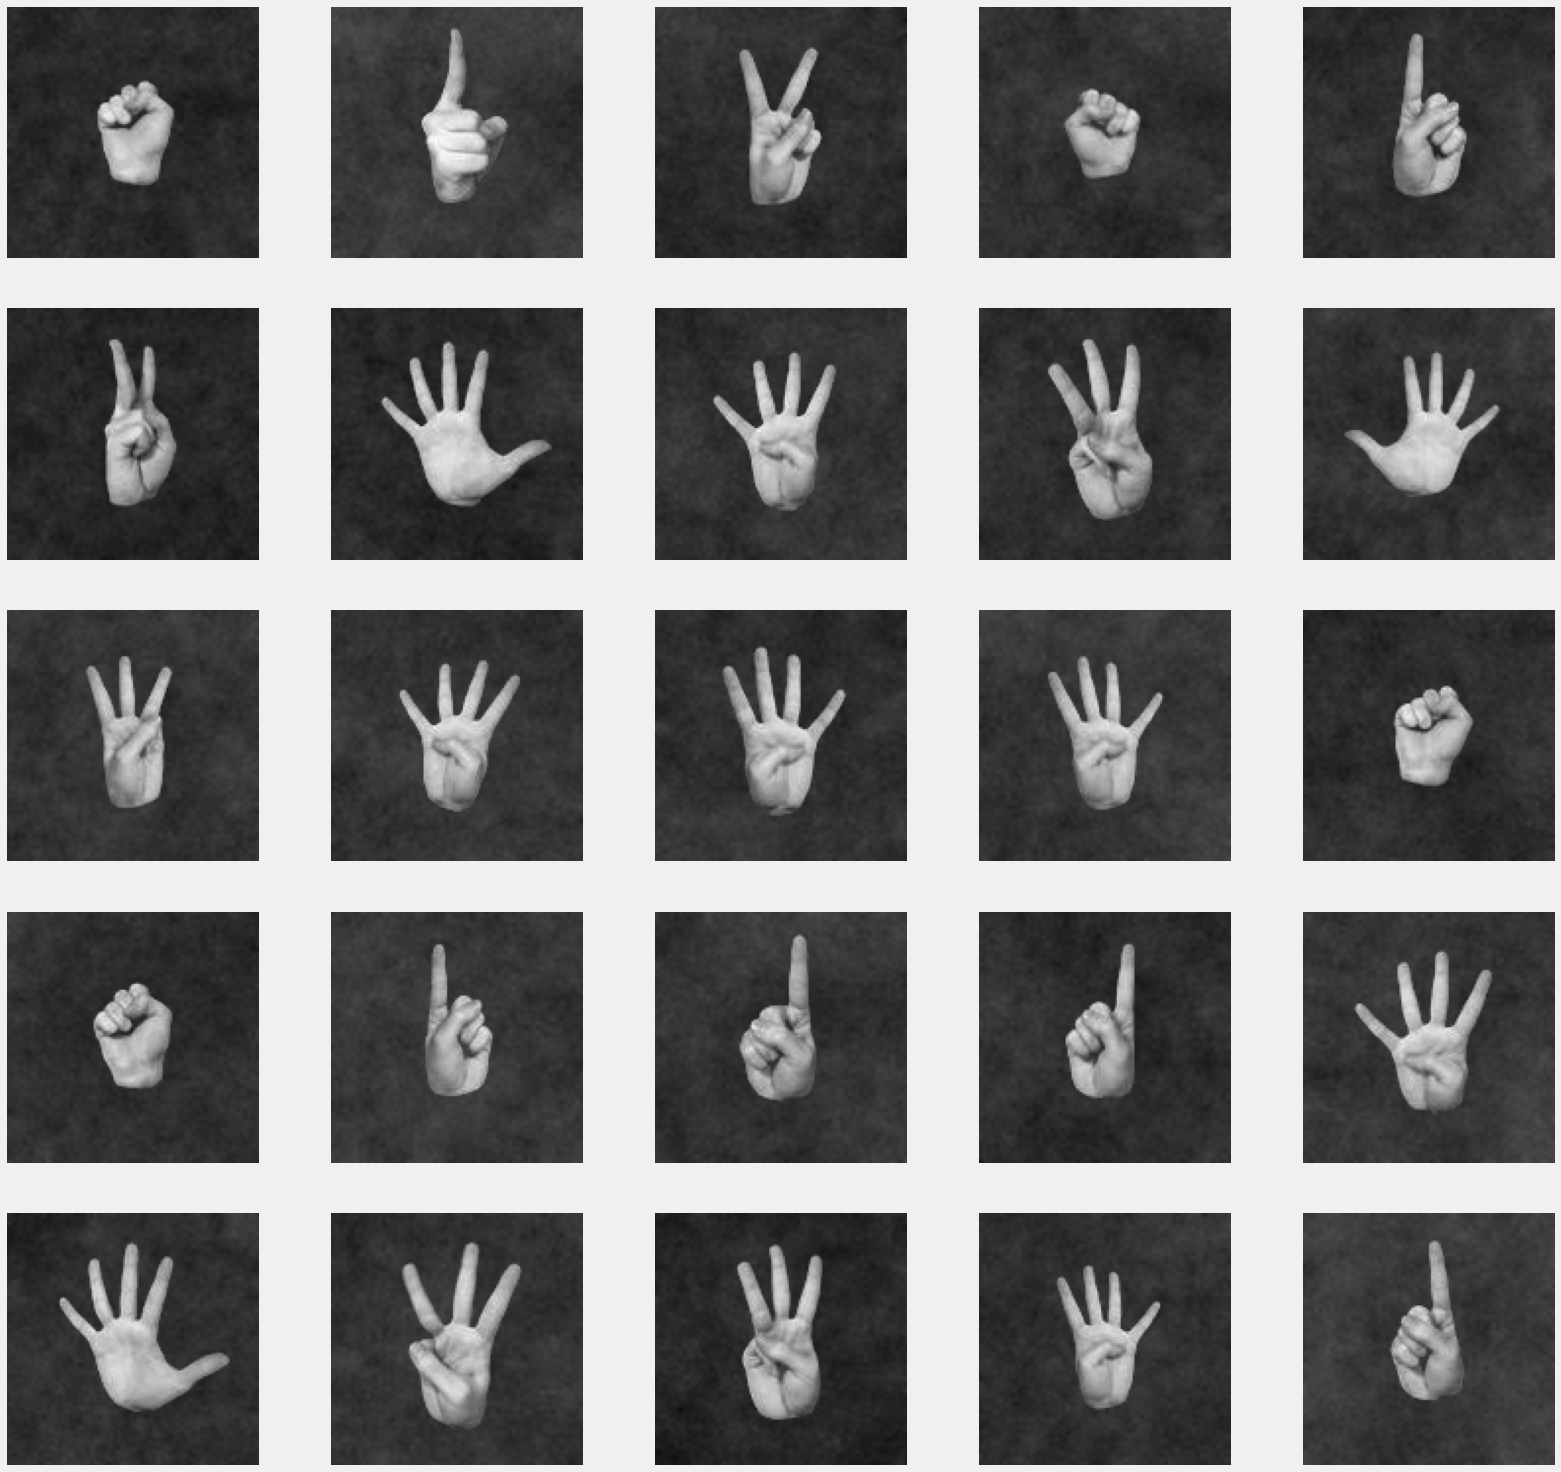

In [ ]:
#lettura immagini test per testare corretto funzionamento della directory
images_test = glob.glob("/content/drive/MyDrive/NEURALNETWORK/DatasetNN/test/*.png")
random_image = random.choice(images_test)

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path_test = random.choice(images_test)
    rand_img_test = imread(random_img_path_test)
    plt.imshow(cv2.cvtColor(rand_img_test, cv2.COLOR_BGR2RGB))
    plt.grid(b=None)
    plt.axis("off")
    plt.xlabel(rand_img_test.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img_test.shape[0], fontsize = 20)#height of image


In [ ]:
#function to extract y labels from base file path
def extract_label(base):
    label = []
    for filename in os.listdir(base):
        label.append(filename.split('.')[0][-2:]) #split on dot and read the preceding 2 literals
    return label

In [ ]:
#list variables holding file paths and y labels for train and test sets
train_set_label = extract_label(train_dir)
test_set_label = extract_label(test_dir)

print("Number of training set examples: ", len(train_set_label))
print("Number of test set examples: ", len(test_set_label))
#nel caricemnto sul drive si sono generati dei file in formato errato quindi 
#ho scritto uno script per rimuoverli

Number of training set examples:  18000
Number of test set examples:  3600


In [ ]:
import matplotlib.pyplot as plt
import os

def plot_class_distribution(base_dir):
    labels = extract_label(base_dir)
    # Count the number of occurrences of each class
    label_counts = {label: labels.count(label) for label in set(labels)}
    for label, count in label_counts.items():
        print(f'Class {label} has {count} items')
    # Get the class labels and counts as separate lists
    class_labels = list(label_counts.keys())
    class_counts = list(label_counts.values())
    # Plot the bar chart
    plt.bar(class_labels, class_counts)
    plt.xlabel('Class Label')
    plt.ylabel('Number of Occurrences')
    plt.show()

In [ ]:
def remove_items_with_wrong_label(base_dir, label_to_remove):
    # Get a list of all files in the base directory
    files = os.listdir(base_dir)
    for file in files:
        # If the file is a PNG file
        if file.endswith('.png'):
            # Extract the label of the current file
            label = file.split(".")[0][-2:]
            # If the label matches the label to remove
            if label == label_to_remove:
                # Construct the full file path
                file_path = os.path.join(base_dir, file)
                # Delete the file
                os.remove(file_path)


In [ ]:
remove_items_with_wrong_label(train_dir, '1)')

Class 0L has 1500 items
Class 2L has 1500 items
Class 1R has 1500 items
Class 4R has 1500 items
Class 3R has 1500 items
Class 3L has 1500 items
Class 1L has 1500 items
Class 0R has 1500 items
Class 5R has 1500 items
Class 2R has 1500 items
Class 4L has 1500 items
Class 5L has 1500 items


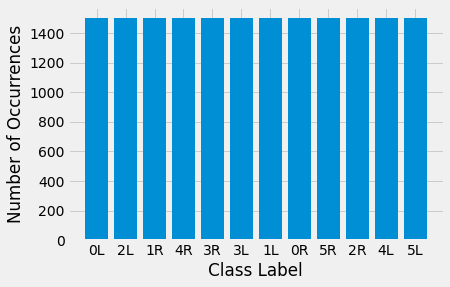

In [ ]:
plot_class_distribution(train_dir)

In [ ]:
import os
import skimage
import cv2

def load_images_and_labels(base_dir):
    images = []
    labels = []
    for file in os.listdir(base_dir):
        # Construct the full path to the image file
        img_path = os.path.join(base_dir, file)
        # Load the image data
        img = cv2.imread(img_path)
        images.append(img)
        # Extract the label of the current file
        label = extract_label(file)
        labels.append(label)
    return images, labels

In [ ]:
#Training set is balanced but number of samples are low so I'll apply now some data augmentation
#The function first calls the load_images_and_labels() function, passing the base_dir as an argument and it will return the images and their labels. 
#Then it converts the labels to the categorical format using the to_categorical() function from keras.utils. 
#Then, it creates an instance of the ImageDataGenerator class, and fit it on the loaded images.
#After that, it continues with the rest of the function as it was before, using the datagen.flow() method to generate the augmented images and save them to the specified directory.
#At the end, it prints the number of generated augmented samples.
#By calling the load_images_and_labels() function before applying data augmentation, you can now load the images and their labels and use them to apply data augmentation using the datagen.fit() method.

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

def apply_data_augmentation(base_dir, save_to_dir, batch_size=32, target_size=(150, 150), seed=42, 
                            save_prefix='augmented', save_format='jpg', n_class_samples=1500):
    # Load the images and their labels
    images, labels = load_images_and_labels(base_dir)
    # Encode the labels to integers
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    # Convert the labels to categorical format
    labels = to_categorical(labels)
    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    # Fit the data generator on the loaded images
    datagen.fit(images)
    # Generate the augmented images
    total_samples = n_class_samples * len(set(labels))
    augmented_samples = 0
    for x_batch, y_batch in datagen.flow(images, labels, batch_size=batch_size, seed=seed, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format):
        augmented_samples += batch_size
        if augmented_samples >= total_samples:
            break
    print(f'Generated {augmented_samples} augmented samples.')

In [ ]:
apply_data_augmentation(train_dir,train_dir)

FileNotFoundError: ignored

In [ ]:
from google.colab import runtime
runtime.unassign()